# Блокнот для изучения метода генерации fGn полей
#TODO: дописать и проверить текст, добавить ссылки

## 1. Теоретический блок

## 2. Принцип синтеза

Метод состоит из трёх шагов.

### Шаг 1 — построение частотной сетки

В n-мериях:

$
{k_1, k_2, \dots, k_d} = \text{FFT frequencies for each axis}
$

и вычисляется:

$
|\mathbf{k}| = \sqrt{k_1^2 + \dots + k_d^2}
$

### Шаг 2 — амплитудное взвешивание по спектру

Мы должны сгенерировать поле, имеющее спектральную плотность (S(k)).

FFT оперирует **амплитудами**, а не мощностями, поэтому:

$
|A(\mathbf{k})| \propto \sqrt{S(\mathbf{k})}
= |\mathbf{k}|^{-(H + d/2)}.
$

Эта формула объясняет, почему в коде:

```python
alpha = hurst + dim / 2.0
S[k>0] = k[k>0] ** (-alpha)
```

### Шаг 3 — генерация случайных фаз и обратное FFT

Создаётся комплексный гауссов шум:

$
W(\mathbf{k}) = \xi(\mathbf{k}) + i \eta(\mathbf{k}),
$

где ( $\xi, \eta \sim \mathcal{N}(0,1)$).

И затем:

$
F(\mathbf{k}) = W(\mathbf{k}) \cdot |A(\mathbf{k})|
$

После обратного FFT:

$
X_H(x) = \mathrm{Re}{\mathrm{IFFT}(F)}.
$

---

### Нормировка

Чаще всего поле масштабируют, для этого в функции `ndfnoise` есть параметр `normalize`

$
X_H(x) \leftarrow \frac{X_H(x) - \mathbb{E}[X_H]}{\sqrt{\mathrm{Var}(X_H)}}.
$

Это обеспечивает универсальность метода в экспериментах.

# 3. Пример использования

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from StatTools.generators.ndfnoise_generator import ndfnoise, ndfnoise_optimized
from StatTools.analysis.dfa import DFA
from StatTools.visualization import plot_ff
from StatTools.analysis import ff_params, var_estimation

In [2]:
%%time
f = ndfnoise((2**8, 2**8, 2**8), hurst=1).real

CPU times: user 1.41 s, sys: 394 ms, total: 1.8 s
Wall time: 2.1 s


In [3]:
%%time
f = ndfnoise_optimized((2**8, 2**8, 2**8), hurst=1).real

CPU times: user 534 ms, sys: 90.2 ms, total: 624 ms
Wall time: 736 ms


In [4]:
def dfa_sliced(arr: np.ndarray) -> np.ndarray:
    """
    Calculate DFA for z slaces.
    """
    if len(arr.shape) != 3:
        h_values = DFA(np.diff(arr)).find_h()
        return h_values
    ny = arr.shape[1]
    nz = arr.shape[2]
    results = np.zeros((nz, ny))

    for i in tqdm(range(nz), desc="sliced 3d DFA"):
        slice_2d = np.diff(arr[:, :, i])
        h_values = DFA(slice_2d).find_h()
        results[i] = h_values
        if i > 10:
            break
    return results

## 2d field

In [ ]:
size = 2**12
for h in [0.5, 0.75, 1.0, 1.25, 1.5]:
    f = ndfnoise_optimized((size, size), hurst=h)
    res = dfa_sliced(f)
    print(f"Ht={h}, Hf Mean +- Std: {np.mean(res):.2f} +- {np.std(res):.2f}")
print(f"Field shape is {f.shape}")

Ht=0.5, Hf Mean +- Std: 0.58 +- 0.02
Ht=0.75, Hf Mean +- Std: 0.80 +- 0.02
Ht=1.0, Hf Mean +- Std: 1.03 +- 0.02
Ht=1.25, Hf Mean +- Std: 1.28 +- 0.03
Ht=1.5, Hf Mean +- Std: 1.51 +- 0.04
Field shape is (4096, 4096)


### Visualisation

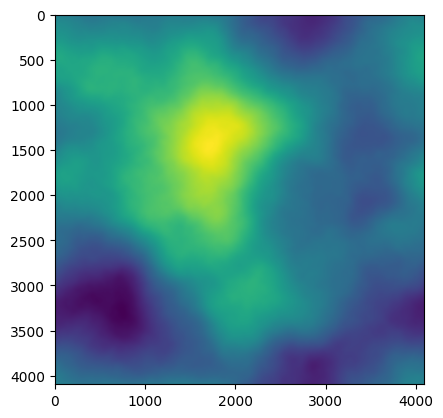

In [6]:
plt.imshow(f)
plt.show()

## 3d field
Note: Only 10 first slices are calculated in `dfa_sliced` for speed up.

In [7]:
size = 2**9
for h in [0.5, 0.75, 1.0, 1.25, 1.5]:
    f = ndfnoise_optimized((size, size, size), hurst=h).real
    res = dfa_sliced(f)[0:10]
    print(f"Ht={h}, Hf Mean +- Std: {np.mean(res):.2f} +- {np.std(res):.2f}")
print(f"Field shape is {f.shape}")

sliced 3d DFA:   2%|▏         | 11/512 [00:46<35:08,  4.21s/it]


Ht=0.5, Hf Mean +- Std: 0.69 +- 0.04


sliced 3d DFA:   2%|▏         | 11/512 [01:01<46:19,  5.55s/it]


Ht=0.75, Hf Mean +- Std: 0.88 +- 0.05


sliced 3d DFA:   2%|▏         | 11/512 [00:52<39:34,  4.74s/it]


Ht=1.0, Hf Mean +- Std: 1.10 +- 0.05


sliced 3d DFA:   2%|▏         | 11/512 [00:53<40:14,  4.82s/it]


Ht=1.25, Hf Mean +- Std: 1.31 +- 0.06


sliced 3d DFA:   2%|▏         | 11/512 [00:46<35:09,  4.21s/it]

Ht=1.5, Hf Mean +- Std: 1.57 +- 0.06
Field shape is (512, 512, 512)


### Visualisation

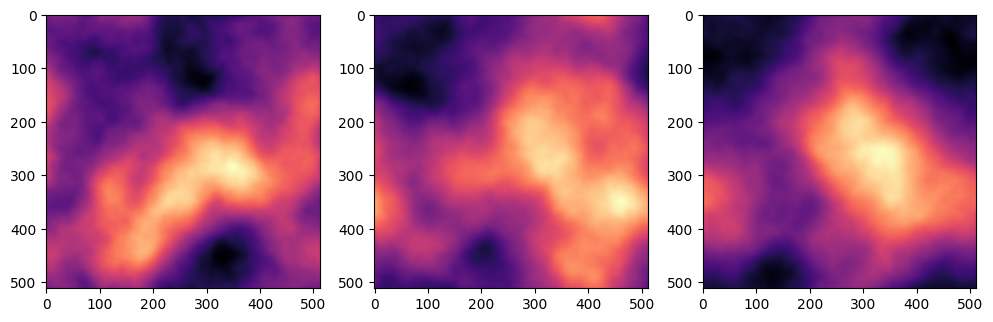

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(f[256, :, :], cmap='magma')
ax[1].imshow(f[:, 256, :], cmap='magma')
ax[2].imshow(f[:, :, 256], cmap='magma')
plt.show()